<a href="https://colab.research.google.com/github/shivendr7/ml/blob/main/UsingHYPEROPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce

We can modify random search adding more attention to the areas where we have already find quite a good solutions. There are different ways to do it. We will consider two of them Tree-structured Parzen Estimator and Simulated Anneal.


First of all let's import some useful functions from the hyperopt:

fmin - the main function for us, it will minimize our functional;
tpe and anneal - optimization approaches;
hp - include different distributions of variables;
Trials - is used for logging

In [1]:
from hyperopt import fmin, tpe, hp, anneal, Trials

In [11]:
from sklearn.model_selection import cross_val_score

In [2]:
_import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import math as m
best = fmin(
    fn=lambda x: -m.sin(25*x)/x,   #in order to maximize a function we minimize -f(x)
    space=hp.uniform('x', -0.5, 2.5),   #hp.uniform is a built-in hyperoptfunction that takes three parameters: the name, x, and the lower and upper bound of the range
    algo=tpe.suggest,
    max_evals=100)
print(best)

100%|██████████| 100/100 [00:00<00:00, 297.80it/s, best loss: -24.217104043971947]
{'x': 0.017421180855855235}


In [5]:
maxima=-best['x']
maxima

-0.017421180855855235

Text(0.5, 1.0, 'sin(25x)/x')

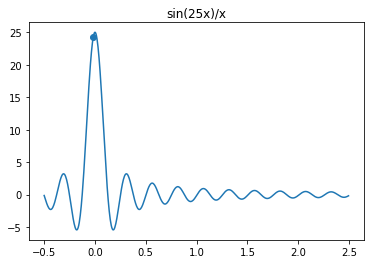

In [6]:
x=np.arange(-.5, 2.5, 0.005)
y=np.sin(25*x)/x
plt.plot(x, y)
plt.scatter(maxima, m.sin(25*maxima)/maxima) # maxima is marked with 'o'
plt.title('sin(25x)/x')

The parameter algo takes a search algorithm, in this case tpe which stands for tree of Parzen estimators.

The algo parameter can also be set to hyperopt.random

##Tree-structured Parzen Estimator
TPE is a default algorithm for the Hyperopt. It uses Bayesian approach for optimization. At every step it is trying to build probabilistic model of the function and choose the most promising parameters for the next step. Generally this types of algorithms works like this:

1. Generate random initial point  x∗ 

2. Calculate  F(x∗)

3. Using the history of trials try to build the conditional probability model  P(F|x)

4. Choose  xi  that according to the  P(F|x)  will most probably result in better  F(xi) 

5. Compute the real value of the  F(xi) 

6. Repeat steps 3-5 until one of the stop criteria is satisfied, for example i > max_eval

More information about particular TPE algorithm you can find, for example, here [https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f ] or in other articles

###Capturing Info with Trials
It would be nice to see exactly what is happening inside the hyperopt black box. The Trials object allows us to do just that. We need only import a few more items.

In [7]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
fspace = {
    'x': hp.uniform('x', -5, 5)
}
def f(params):
    x = params['x']
    val = x**2
    return {'loss': val, 'status': STATUS_OK}
trials = Trials()
best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=50, trials=trials)
print('best:', best)
print('trials:', trials.trials)
for trial in trials.trials[:2]:
    print(trial)

100%|██████████| 50/50 [00:00<00:00, 379.78it/s, best loss: 0.0019545781039108793]
best: {'x': 0.04421061076156808}
trials: [{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 4.461995427788681, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [0]}, 'vals': {'x': [2.1123435865854496]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2021, 7, 6, 22, 4, 54, 159000), 'refresh_time': datetime.datetime(2021, 7, 6, 22, 4, 54, 160000)}, {'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 18.451652114500373, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [1]}, 'vals': {'x': [4.295538629147732]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2021, 7, 6, 22, 4, 54, 161000), 'refresh_time': datetime.datetime(2021, 7, 6, 22, 4, 54, 161000)}, {'state': 2, 'tid': 2, 'spec': None, 'result': {'loss

Now let’s look at the plot of loss vs. val.

Text(0, 0.5, '$val$')

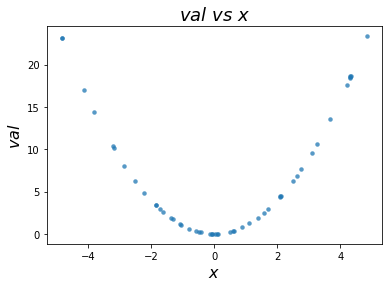

In [8]:
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['x'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$val$ $vs$ $x$ ', fontsize=18)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$val$', fontsize=16)

In [12]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,100))
}

def f(params):
    acc = hyperopt_train_test(params) #accuracy
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print('best:', best)

100%|██████████| 100/100 [00:02<00:00, 42.02it/s, best loss: -0.9800000000000001]
best: {'n_neighbors': 9}


In [13]:
d={'val1':1, 'val2':2, 'val3':3}
def check(val1=5, val2=6, val3=7, val8=2):
  print(val1, val2, val3, val8)
check(**d)  # '**(dict)' matches the dict keys and values to positional arguments

1 2 3 2
